In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
ds = fetch_california_housing()
x  = ds.data
y  = ds.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16512, 8)
(16512,)
(4128, 8)
(4128,)


In [4]:
number_of_training_iters = 201;
batch_size = 2000;

Normalization of the data points

In [5]:
def norm(x, mean, std):
    return (x - mean) / std

mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train_normalized = norm(x_train, mean, std)
x_test_normalized = norm(x_test, mean, std)

In [6]:
tensor_x_train = torch.tensor(x_train_normalized).float()
tensor_y_train = torch.tensor(y_train).view(-1, 1).float() # .view(-1, 1) is just to get a 1 on that second shape axis to not confuse torch
tensor_x_test = torch.tensor(x_test_normalized).float()
tensor_y_test = torch.tensor(y_test).view(-1, 1).float() # .view(-1, 1) is just to get a 1 on that second shape axis to not confuse torch

datasets = torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=batch_size, shuffle=True)

datasets = torch.utils.data.TensorDataset(tensor_x_test, tensor_y_test)
test_iter = torch.utils.data.DataLoader(datasets, batch_size=y_test.shape[0], shuffle=False)

In [7]:
class mdl(nn.Module):
    def __init__(self):
        super(mdl, self).__init__()
        self.input_layer    = nn.Linear(8, 16)
        self.hidden_layer1  = nn.Linear(16, 32)
        self.hidden_layer2  = nn.Linear(32, 20)
        self.output_layer   = nn.Linear(20, 1)
        self.activation_fcn = nn.ReLU()
    def forward(self, x):
        x = self.activation_fcn(self.input_layer(x))
        x = self.activation_fcn(self.hidden_layer1(x))
        x = self.activation_fcn(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x

In [8]:
model = mdl()
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
for i in range(number_of_training_iters):
    running_loss = 0.0
    running_size = 0.0
    for inputs, labels in train_iter:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_size += inputs.shape[0]
        running_loss += loss.item()
    if i % 20 == 0:
        print('Epoch [%d]/[%d] running accumulative average loss across all batches: %.5f' %
              (i + 1, number_of_training_iters, running_loss / running_size))

Epoch [1]/[201] running accumulative average loss across all batches: 5.59945
Epoch [21]/[201] running accumulative average loss across all batches: 0.58815
Epoch [41]/[201] running accumulative average loss across all batches: 0.41785
Epoch [61]/[201] running accumulative average loss across all batches: 0.37363
Epoch [81]/[201] running accumulative average loss across all batches: 0.35246
Epoch [101]/[201] running accumulative average loss across all batches: 0.33693
Epoch [121]/[201] running accumulative average loss across all batches: 0.32672
Epoch [141]/[201] running accumulative average loss across all batches: 0.31923
Epoch [161]/[201] running accumulative average loss across all batches: 0.31277
Epoch [181]/[201] running accumulative average loss across all batches: 0.30822
Epoch [201]/[201] running accumulative average loss across all batches: 0.30201


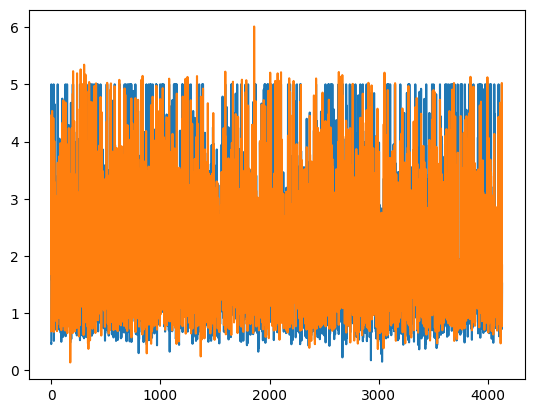

In [10]:
for inputs, labels in test_iter:
    outputs = model(inputs)
    loss = criterion(outputs, labels)
import matplotlib.pyplot as plt
plt.plot(labels)
plt.plot(outputs.detach().numpy())

In [11]:
print(model.input_layer.weight.shape)

torch.Size([16, 8])


In [12]:
with np.printoptions(precision=4, suppress=True, linewidth=400):
    print(model.input_layer.weight.detach().numpy())

[[ 0.0148 -0.0087 -0.2022  0.1607  0.0767 -1.6657 -0.0885 -0.047 ]
 [ 0.0193 -0.037   0.0508 -0.1403 -0.1172  0.0313 -0.356  -0.4544]
 [ 0.2891 -0.2703 -0.0437  0.348   0.1369 -0.0165  0.0584 -0.0168]
 [ 0.3201 -0.0398  0.0192 -0.1022  0.0551  0.1529 -0.6598  0.358 ]
 [-0.0135  0.2973 -0.1884  0.0407  0.0476  0.0023 -0.2346  0.005 ]
 [-0.0632  0.0668 -0.4219  0.2819  0.1601  0.8233 -0.1062 -0.0828]
 [ 0.4178 -0.3416  0.4535 -0.1857  0.0011  0.1979 -0.3868  0.1148]
 [-0.0239  0.0316 -0.0609  0.0528  0.0611  0.0635 -0.2003  0.5565]
 [-0.1182 -0.4197 -0.4447 -0.1994 -0.0014 -0.3713 -0.2574 -0.2088]
 [-0.3759  0.1136  0.1395  0.065  -0.2157  0.1052  0.0771  0.2912]
 [ 0.3723  0.1233 -0.3353 -0.2324 -0.1639  0.3308  0.0744  0.2428]
 [ 0.2244  0.124   0.1311  0.0299  0.169  -1.0678 -0.3305 -0.3277]
 [-0.0403 -0.0135 -0.0907 -0.0339 -0.1073 -0.6806 -0.3054  0.316 ]
 [ 0.0613 -0.2638 -0.0593 -0.3561 -0.0317  0.0947 -0.2902 -0.2657]
 [ 0.3702  0.1553  0.3393 -0.0107 -0.1137 -0.8234 -0.1873  0.2

In [13]:
print(model.input_layer.bias.shape)

torch.Size([16])


In [14]:
with np.printoptions(precision=4, suppress=True, linewidth=400):
    print(model.input_layer.bias.detach().numpy())

[ 0.0105  0.4207 -0.006   0.2591  0.1875  0.5838  0.0331 -0.4866 -0.286   0.1506 -0.0532  0.2357  0.0392  0.2913 -0.1472  0.1521]


In [15]:
print(model.hidden_layer1.weight.shape)

torch.Size([32, 16])


In [16]:
with np.printoptions(precision=4, suppress=True, linewidth=400):
    print(model.hidden_layer1.weight.detach().numpy())

[[ 0.0069 -0.0166  0.1982 -0.0916  0.2745  0.0553  0.2718 -0.2341  0.0587  0.1835 -0.0467  0.2029 -0.1198  0.2337  0.2976  0.0107]
 [ 0.4912  0.2152  0.0099  0.1178  0.068  -0.1274  0.1845 -0.4481 -0.1747  0.0463 -0.0974 -0.0333  0.3725 -0.0073  0.2782  0.428 ]
 [ 0.2141 -0.0766  0.1483  0.0921  0.0435  0.2169  0.1753 -0.2602  0.1344 -0.0359 -0.0731  0.3092 -0.045   0.2407 -0.0783  0.0303]
 [ 0.7683 -0.2562  0.4828 -0.1976 -0.3373  0.2885 -0.1786 -0.0196  0.3208  0.1316  0.2888  0.3193 -0.1758 -0.5671  0.5591  0.4233]
 [ 0.3288  0.3194 -0.1067 -0.0821  0.0282 -0.1998  0.2555 -0.3043  0.1107 -0.0517 -0.128   0.2167  0.1603  0.2058  0.1767 -0.0629]
 [-0.3476 -0.0479 -0.4579 -0.341   0.055   0.1282 -0.0577  0.0262 -0.0616  0.0397  0.2081 -0.1891  0.2321 -0.019   0.3255  0.0032]
 [ 0.3806  0.2628  0.067  -0.1151 -0.0895 -0.4673 -0.3088 -0.0558 -0.2526 -0.0229 -0.2416  0.1623  0.2516  0.1063  0.2098  0.2004]
 [-0.1739 -0.1463 -0.0296  0.0386  0.3526 -0.1969  0.2704  0.6028  0.1159 -0.094   

# Analyses on the parameters to get fixed-point implementations

In [17]:
running_loss = 0.0
running_size = 0.0
for inputs, labels in train_iter:
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_size += inputs.shape[0]
    running_loss += loss.item()
print('Average Train Loss: %.5f' % (running_loss / running_size))

Average Train Loss: 0.30180


In [18]:
running_loss = 0.0
running_size = 0.0
for inputs, labels in test_iter:
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_size += inputs.shape[0]
    running_loss += loss.item()
print('Average Test Loss: %.5f' % (running_loss / running_size))

Average Test Loss: 0.31742


Seems like the first layer doesn't need a decimal part, let's assign a Q0.7

In [19]:
input_layer_weights = model.input_layer.weight.detach().numpy()

input_layer_weights = np.round( input_layer_weights * ((2**8)-1) ) / ((2**8)-1)   # now we've quantized them, some values are not available anymore.

with np.printoptions(precision=4, suppress=True, linewidth=400):
    print(input_layer_weights)

[[ 0.0157 -0.0078 -0.2039  0.1608  0.0784 -1.6667 -0.0902 -0.0471]
 [ 0.0196 -0.0353  0.051  -0.1412 -0.1176  0.0314 -0.3569 -0.4549]
 [ 0.2902 -0.2706 -0.0431  0.349   0.1373 -0.0157  0.0588 -0.0157]
 [ 0.3216 -0.0392  0.0196 -0.102   0.0549  0.1529 -0.6588  0.3569]
 [-0.0118  0.298  -0.1882  0.0392  0.0471  0.0039 -0.2353  0.0039]
 [-0.0627  0.0667 -0.4235  0.2824  0.1608  0.8235 -0.1059 -0.0824]
 [ 0.4196 -0.3412  0.4549 -0.1843  0.      0.1961 -0.3882  0.1137]
 [-0.0235  0.0314 -0.0627  0.051   0.0627  0.0627 -0.2     0.5569]
 [-0.1176 -0.4196 -0.4431 -0.2    -0.     -0.3725 -0.2588 -0.2078]
 [-0.3765  0.1137  0.1412  0.0667 -0.2157  0.1059  0.0784  0.2902]
 [ 0.3725  0.1216 -0.3373 -0.2314 -0.1647  0.3294  0.0745  0.2431]
 [ 0.2235  0.1255  0.1294  0.0314  0.1686 -1.0667 -0.3294 -0.3294]
 [-0.0392 -0.0118 -0.0902 -0.0353 -0.1059 -0.6824 -0.3059  0.3176]
 [ 0.0627 -0.2627 -0.0588 -0.3569 -0.0314  0.0941 -0.2902 -0.2667]
 [ 0.3686  0.1569  0.3412 -0.0118 -0.1137 -0.8235 -0.1882  0.2

Let's reassign those weights

In [20]:
model.input_layer.weight = torch.nn.Parameter(torch.Tensor(input_layer_weights))

let's see the accuracy again

In [21]:
running_loss = 0.0
running_size = 0.0
for inputs, labels in test_iter:
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_size += inputs.shape[0]
    running_loss += loss.item()
print('Average Test Loss: %.5f' % (running_loss / running_size))

Average Test Loss: 0.31733


now let's throw out a few more bits to see how the accuracy gets affected, Q0.3

In [22]:
input_layer_weights = model.input_layer.weight.detach().numpy()
input_layer_weights = np.round( input_layer_weights * ((2**4)-1) ) / ((2**4)-1)
with np.printoptions(precision=4, suppress=True, linewidth=400):
    print(input_layer_weights)

[[ 0.     -0.     -0.2     0.1333  0.0667 -1.6667 -0.0667 -0.0667]
 [ 0.     -0.0667  0.0667 -0.1333 -0.1333  0.     -0.3333 -0.4667]
 [ 0.2667 -0.2667 -0.0667  0.3333  0.1333 -0.      0.0667 -0.    ]
 [ 0.3333 -0.0667  0.     -0.1333  0.0667  0.1333 -0.6667  0.3333]
 [-0.      0.2667 -0.2     0.0667  0.0667  0.     -0.2667  0.    ]
 [-0.0667  0.0667 -0.4     0.2667  0.1333  0.8    -0.1333 -0.0667]
 [ 0.4    -0.3333  0.4667 -0.2     0.      0.2    -0.4     0.1333]
 [-0.      0.     -0.0667  0.0667  0.0667  0.0667 -0.2     0.5333]
 [-0.1333 -0.4    -0.4667 -0.2    -0.     -0.4    -0.2667 -0.2   ]
 [-0.4     0.1333  0.1333  0.0667 -0.2     0.1333  0.0667  0.2667]
 [ 0.4     0.1333 -0.3333 -0.2    -0.1333  0.3333  0.0667  0.2667]
 [ 0.2     0.1333  0.1333  0.      0.2    -1.0667 -0.3333 -0.3333]
 [-0.0667 -0.     -0.0667 -0.0667 -0.1333 -0.6667 -0.3333  0.3333]
 [ 0.0667 -0.2667 -0.0667 -0.3333 -0.      0.0667 -0.2667 -0.2667]
 [ 0.4     0.1333  0.3333 -0.     -0.1333 -0.8    -0.2     0.2

In [24]:
model.input_layer.weight = torch.nn.Parameter(torch.Tensor(input_layer_weights))

In [25]:
running_loss = 0.0
running_size = 0.0
for inputs, labels in test_iter:
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_size += inputs.shape[0]
    running_loss += loss.item()
print('Average Test Loss: %.5f' % (running_loss / running_size))

Average Test Loss: 0.35574
